1. **Problem -1:**
For this exercise, I have selected SQLite as the database system due to its simplicity, zero-configuration setup, and suitability for local development and scripting use cases. The goal is to model and store daily weather observations collected from multiple weather stations located across five U.S. states.
**Data Model overview:**
**Assumptions**
As the sample input does not explicitly provide weather station metadata (such as station name or state), I have assumed that each input file corresponds to a unique weather station. Based on this, I adopted a filename convention of the format:
State_StationName.txt
This naming convention allows us to extract the station's name and associated state from the file name during ingestion.
**Schema Design:**
I have created two tables:
a. weather_station which stores station metadata(name, location)
b. weather_records which store information about weather metadata (record_date, min/max temp, precipitation)

In [2]:
import sqlite3

In [3]:
conn = sqlite3.connect('weather.db')  # This creates a file-based SQLite database
cursor = conn.cursor()

In [4]:
##Table to store weather station information
cursor.execute('''
CREATE TABLE IF NOT EXISTS Weather_Stations (
    station_id INTEGER PRIMARY KEY AUTOINCREMENT,  -- Unique identifier for the weather station
    station_name TEXT NOT NULL,                    -- Name of the weather station (e.g., station code)
    state TEXT NOT NULL                          -- State where the station is located (e.g., Nebraska, Iowa)
)
'''
)
conn.commit

<function Connection.commit()>

In [6]:
# create a table for weather_records
cursor.execute('''
CREATE TABLE IF NOT EXISTS weather_records(
    record_id INTEGER PRIMARY KEY AUTOINCREMENT,   -- Unique identifier for each weather record
    station_id INTEGER NOT NULL,
    record_date INTEGER NOT NULL,                  -- Date in YYYYMMDD format
    max_temp INTEGER,                              -- Max temperature for the day in tenths of a degree Celsius
    min_temp INTEGER,                              -- Min temperature for the day in tenths of a degree Celsius
    precipitation INTEGER,                         -- Precipitation for the day in tenths of a millimeter
    FOREIGN KEY (station_id) REFERENCES Weather_Stations (station_id),
    CHECK (record_date BETWEEN 19850101 AND 20141231),
    UNIQUE (station_id, record_date)               -- Composite uniqueness constraint

)
'''
)
conn.commit

<function Connection.commit()>

In [7]:
#TO CHECK ALL THE TABLES CREATED IN DATABASE

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:", tables)

Tables in database: [('Weather_Stations',), ('sqlite_sequence',), ('weather_records',)]


Problem -2: Data Ingestion
The script below implements a data ingestion process that meets the following requirements:

**Duplicate Handling:**
Before inserting each record, the script checks whether a record with the same station_id and record_date already exists in the database. If found, the record is skipped to prevent duplication — making the process safe to run multiple times without re-inserting the same data.

**Missing Value Handling:**
Any missing values in the raw weather files, represented by -9999, are automatically converted to NULL during ingestion to preserve data integrity.

**Logging and Metrics:**
The script logs the start and end time of the ingestion process and reports the total number of records inserted. It also prints detailed status messages for each file processed.

In [10]:
import os
from google.colab import files
from datetime import datetime

# Step 1: Upload multiple files
uploaded = files.upload()
filenames = list(uploaded.keys())

# Step 2: Parse station names and states from filenames
def station_name_filename(filenames):
    station_info = {}
    for filename in filenames:
        name = os.path.splitext(filename)[0]
        parts = name.split('_')
        if len(parts) < 2:
            raise ValueError("Filename must be in 'State_StationName.txt' format")
        state = parts[0].capitalize()
        station_name = '_'.join(parts[1:]).upper()
        station_info[filename] = (station_name, state)
    return station_info

# Step 3: Insert stations into Weather_Stations table (if not exists)
def get_station(station_info_dict):
    station_ids = {}
    for station_name, state in set(station_info_dict.values()):
        station_name = station_name.upper()
        state = state.capitalize()
        cursor.execute("SELECT station_id FROM Weather_Stations WHERE station_name=? AND state=?", (station_name, state))
        row = cursor.fetchone()
        if row:
            station_id = row[0]
        else:
            cursor.execute(
                "INSERT INTO Weather_Stations (station_name, state) VALUES (?, ?)",
                (station_name, state)
            )
            conn.commit()
            station_id = cursor.lastrowid
        station_ids[(station_name, state)] = station_id
    return station_ids

# Step 4: Convert raw value to float (handle -9999 as missing)
def parse_value(raw, scale):
    val = int(raw)
    return None if val == -9999 else val / scale

# Step 5: Ingest data from files
def ingest_weather_data(filenames, station_info, station_ids):
    total_records = 0
    start_time = datetime.now()

    for filename in filenames:
        station_name, state = station_info[filename]
        key = (station_name.upper(), state.capitalize())
        station_id = station_ids.get(key)

        if station_id is None:
            print(f"[WARN] Station ID not found for {filename}")
            continue

        inserted = 0
        with open(filename, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) != 4:
                    continue
                date, max_temp_raw, min_temp_raw, precip_raw = parts
                max_temp = parse_value(max_temp_raw, 10)
                min_temp = parse_value(min_temp_raw, 10)
                precip = parse_value(precip_raw, 10)

                # Avoid inserting duplicates
                cursor.execute('''
                    SELECT 1 FROM weather_records WHERE record_date = ? AND station_id = ?
                ''', (date, station_id))
                if cursor.fetchone():
                    continue  # already exists

                cursor.execute('''
                    INSERT INTO weather_records (station_id, record_date, max_temp, min_temp, precipitation)
                    VALUES (?, ?, ?, ?, ?)
                ''', (station_id, date, max_temp, min_temp, precip))
                inserted += 1

        conn.commit()
        print(f"[INFO] {filename} -> Inserted {inserted} records.")
        total_records += inserted

    end_time = datetime.now()
    print(f"[LOG] Ingestion started at: {start_time}")
    print(f"[LOG] Ingestion ended at:   {end_time}")
    print(f"[LOG] Total records inserted: {total_records}")

# Step 6: Run everything
station_info = station_name_filename(filenames)
station_ids = get_station(station_info)
ingest_weather_data(filenames, station_info, station_ids)


Saving Indiana_station2.txt to Indiana_station2.txt
Saving Indiana_station3.txt to Indiana_station3.txt
[INFO] Indiana_station2.txt → Inserted 10 records.
[INFO] Indiana_station3.txt → Inserted 10 records.
[LOG] Ingestion started at: 2025-05-06 05:35:30.775567
[LOG] Ingestion ended at:   2025-05-06 05:35:30.786692
[LOG] Total records inserted: 20


Problem -3 : Data Analysis
Data Model Overview: To support annual weather data analysis, I designed a new table called weather_statistics to store aggregated metrics for each weather station by year.

The ingestion process involves:

Querying and aggregating raw weather data from the weather_records table.

Calculating the following statistics for each station and year:

Average maximum temperature (°C)

Average minimum temperature (°C)

Total accumulated precipitation (converted to centimeters)

Ignoring missing values (NULL) during aggregation to ensure statistical accuracy.

Inserting the results into the weather_statistics table for efficient retrieval and reporting.

In [27]:
#Create the weather statistics table for data analysis
cursor.execute('''
CREATE TABLE IF NOT EXISTS weather_statistics (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    station_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    avg_max_temp_celsius REAL,
    avg_min_temp_celsius REAL,
    total_precip_cm REAL,
    FOREIGN KEY (station_id) REFERENCES Weather_Stations(station_id)
)
''')
conn.commit()

In [28]:
#calculate the data analysis
cursor.execute('''
SELECT
station_id,
SUBSTR(record_date, 1, 4) AS year,
AVG(max_temp) AS avg_max,
AVG(min_temp) AS avg_min,
SUM(precipitation) / 10.0 AS total_precip_cm
FROM weather_records
GROUP BY station_id, year
''')
stats = cursor.fetchall()

In [29]:
#insert into weather_statistics
for station_id, year, avg_max, avg_min, total_precip in stats:
    cursor.execute('''
        INSERT INTO weather_statistics (
            station_id, year, avg_max_temp_celsius, avg_min_temp_celsius, total_precip_cm
        ) VALUES (?, ?, ?, ?, ?)
    ''', (station_id, int(year), avg_max, avg_min, total_precip))

conn.commit()
print(f"[INFO] Inserted {len(stats)} rows into weather_statistics.")

[INFO] Inserted 2 rows into weather_statistics.


Problem -4 ETL process
I developed an ETL (Extract, Transform, Load) script to automate the daily ingestion of weather data files. The script handles the following tasks:

Extract:
Periodically checks a specified local directory for new weather data files.

Transform:
Cleans and preprocesses the raw data by:

Handling missing values (converting -9999 to NULL)

Converting temperature and precipitation units to standard formats

Avoiding duplicate entries by checking for existing records in the database

Load:
Inserts the cleaned and validated data into the SQLite database (weather_records and weather_stations), ensuring no duplicate records are added.

To automate this process, I configured Windows Task Scheduler to execute the ETL script daily, in line with the assumption that new weather data is received each day. The script only processes and inserts new data, making it safe to run repeatedly.

Logging:
After each ETL run, a log entry is written to an etl_log.txt file. This log includes the start and end timestamps of the ingestion process, the number of files processed, and the total number of records successfully inserted.

Future Enhancement:
To further improve traceability and prevent reprocessing, an archive folder can be introduced to store processed input files. Although not implemented yet, this enhancement is recommended for long-term file management.![TaskScheduler.JPG](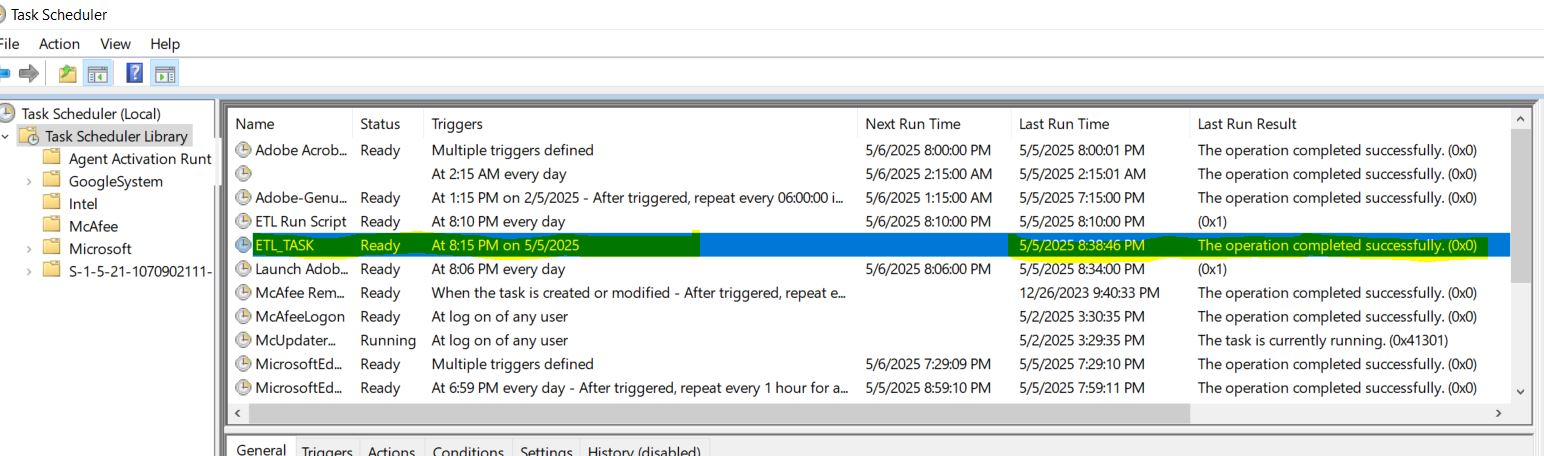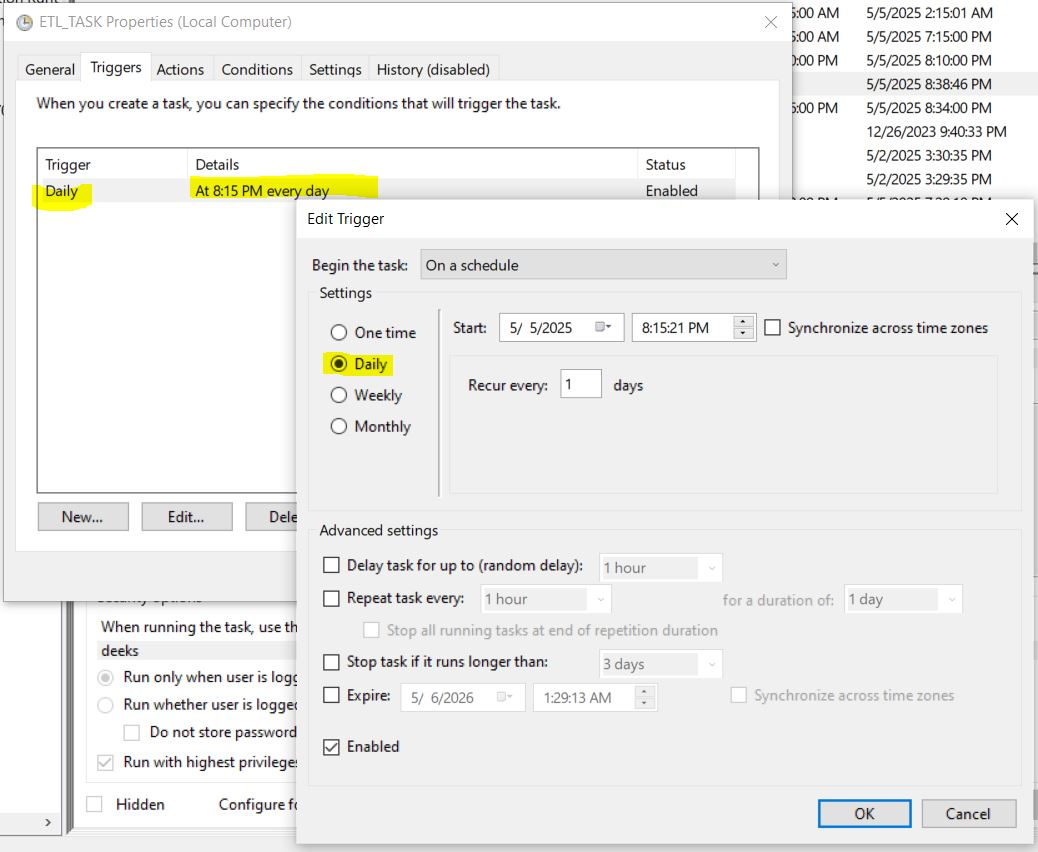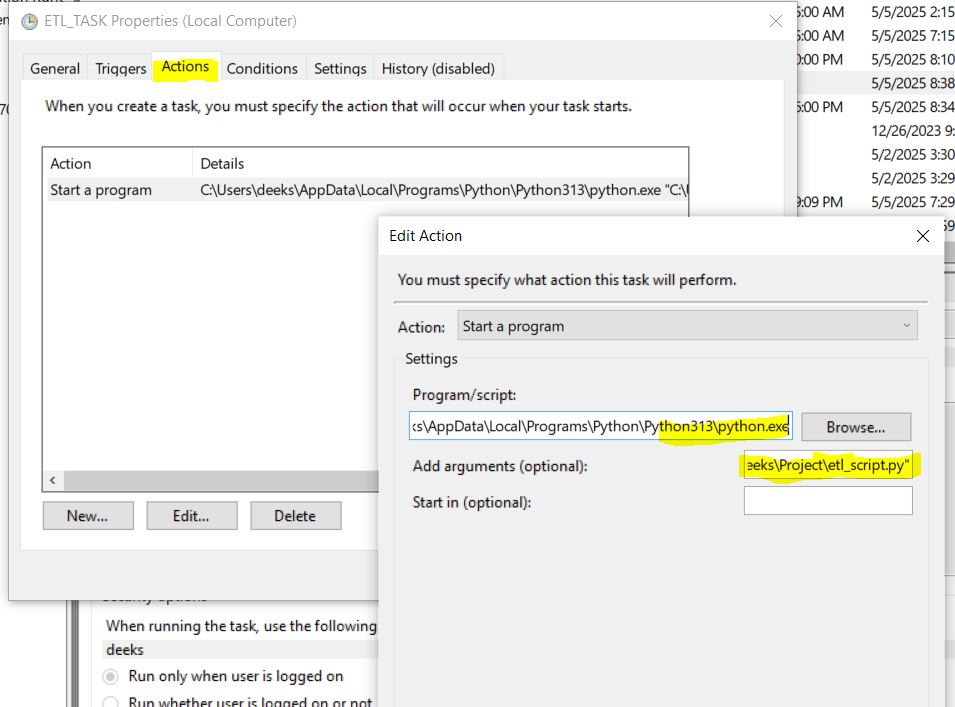)

In [11]:
import pandas as pd
df = pd.read_sql_query("SELECT * FROM weather_stations", conn)
print(df)

   station_id station_name    state
0           1     STATION3  Indiana
1           2     STATION2  Indiana


In [12]:
df = pd.read_sql_query("SELECT * FROM weather_records", conn)
print(df)

    record_id  station_id  record_date  max_temp  min_temp  precipitation
0           1           2     19850101       1.1     -12.2           34.8
1           2           2     19850102     -10.6     -18.3            0.3
2           3           2     19850103      -5.6     -18.3            0.0
3           4           2     19850104      -1.7     -16.1            0.0
4           5           2     19850105       1.7      -6.1            0.0
5           6           2     19850106       2.8      -3.9            0.0
6           7           2     19850107       1.7      -1.7            0.0
7           8           2     19850108      -1.1     -10.0            0.0
8           9           2     19850109      -2.2     -10.6            0.0
9          10           2     19850110      -2.8      -9.4            2.8
10         11           1     20140527      31.1      18.9            1.3
11         12           1     20140528      29.4      17.2           17.3
12         13           1     20140529

In [30]:
df = pd.read_sql_query("SELECT * FROM weather_statistics", conn)
print(df)

   id  station_id  year  avg_max_temp_celsius  avg_min_temp_celsius  \
0   1           1  2014                 27.33                 15.73   
1   2           2  1985                 -1.67                -10.66   

   total_precip_cm  
0             2.97  
1             3.79  
